## Double Well Potential with MCMC

Paul Cretegny, Ethan Newell, Katya Sumwalt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba 
import tqdm
import scipy as scipy


Consider the double well potential,
$$ V(x) = αx^4 -2x^2 + \frac{1}{α}$$
where x is the position of the particle, and we set m = h_bar = 1 and α = 0.4. See Refs. [1, 2] for discussions of
similar problems.

Use the path integral formulation with imaginary time τ:

$$ Z = \int\ Dx(τ) exp [-\frac{1}{h} \oint_{0}^{\tau_b} L_E(x(τ))dτ \, dx] $$



Problem A : Evaluate the ground state energy and probability distribution of the particle using Markov
chain Monte Carlo with the Metropolis-Hastings algorithm in the large-τb (imaginary time) limit. Describe
your strategy for determining τb, the initial configuration, burn-in steps, hit size, number of sweeps, and
thinning (if any).


In [2]:
SWEEPS = 10_000
TAU = 300
DTAU = 1
NTAU = int(TAU/DTAU)
HIT = 0.5
ALPHA = 0.4

XMIN = -4
XMAX = 4
NXBINS = 1000
OMEGA = 1
M = 1
DX = (XMAX - XMIN) / NXBINS
prob_hist = np.zeros(NXBINS)

x_bins = np.linspace(XMIN, XMAX, NXBINS + 1)
x_path = np.zeros(NTAU)
x = np.linspace(XMIN, XMAX, NXBINS + 1)

SweepActions = []

In [3]:
# Potential Well
def V(x):
    return ALPHA * x**4 - 2 * x**2 + 1/ALPHA

def dVdx(x):
    return 4 * ALPHA * x**3 - 4 * x

# Define Path Variance
def vary_path(x_i):
    x_prime = x_i + np.random.random() * 2 * HIT - HIT
    while x_prime > XMAX or x_prime < XMIN:
        x_prime = x_i + np.random.random() * 2 * HIT - HIT
    return x_prime

# Define our Action S
def Action(left, right):
    K = 0.5 * M * (((right - left)**2) / DTAU)
    v = 0.5 * M * DTAU * (OMEGA**2) * V((left + right) / 2)
    return K + v

# Define the total action 
def total_action(x_path):
    path_action = 0
    for i in range(-1, NTAU-1):
        path_action += Action(x_path[i], x_path[i+1])
    return path_action
                   
# Define difference in action
def delta_action(x_path, x_prime, i):
    left = x_path[i-1]
    right = x_path[i+1] if i < NTAU-1 else x_path[0]
    daction = Action(left, x_prime) + Action(x_prime, right)
    daction -= Action(left, x_path[i]) + Action(x_path[i], right)
    return daction
                   
# Calculate Ground State using MCMC histogram
def Ground(state):
    norm = state / np.sum(state * DX)
    K = np.real(0.5 * np.sum(DX * np.diff(np.sqrt(norm))*np.diff(np.sqrt(norm)) / DX**2))
    VG = np.sum(norm * V(x[:-1])) * DX
    E_0 = (K + VG)
    return E_0

# Define MCMC function
def MCMC(x_path, prob_hist,x2Sample,x4Sample):
    accepted = 0
    for i in range(NTAU):
        x_prime = vary_path(x_path[i])
        daction = delta_action(x_path, x_prime, i)
        if daction <= 0:
            x_path[i] = x_prime
            accepted += 1
        else: 
            prob = np.exp(-daction)
            if np.random.random() < prob:
                x_path[i] = x_prime
                accepted += 1
        
    hist, _ = np.histogram(x_path, bins = x_bins)
    prob_hist += hist
    x2Sample.append(np.mean(x_path**2))
    x4Sample.append(np.mean(x_path**4))

    return accepted

In [4]:
# Create expected dist.
H = np.zeros((NXBINS + 1, NXBINS + 1))
for i in range(NXBINS + 1):
    for j in range(NXBINS + 1):
        H[i,j] = - (0.5 / DX**2) * ((i + 1 == j) - 2 * (i == j) + (i - 1 == j))
        H[i,j] += V(x[i]) * (i == j)

Es, psis = scipy.sparse.linalg.eigsh(H, k=2, sigma=1.5, which='LM')

E0 = Es[0]
psi0 = psis[:,0]

# normalize psi0
psi0 /= np.sqrt(np.sum(psi0.conjugate() * psi0) * DX)
normed = np.abs(psi0)**2
normed /= np.sum(normed) * DX

In [5]:
x2Sample = []
x4Sample = []
E_0_list = []
for k in tqdm.tqdm(range(int(SWEEPS))):
    MCMC(x_path, prob_hist,x2Sample,x4Sample)
    E_0_list.append(0.5*(3*ALPHA*x4Sample[-1] - 4*x2Sample[-1] + 1/ALPHA))
    
avgx2 = np.mean(x2Sample)
avgx4 = np.mean(x4Sample)

print(f'Avg Energy {0.5*(3*ALPHA*avgx4 -4*avgx2 + 1/ALPHA)}')

100%|██████████| 10000/10000 [00:51<00:00, 192.85it/s]

Avg Energy 1.2057685308894932


Problem B: Plot the ground state probability distribution and compare it with the expected form.

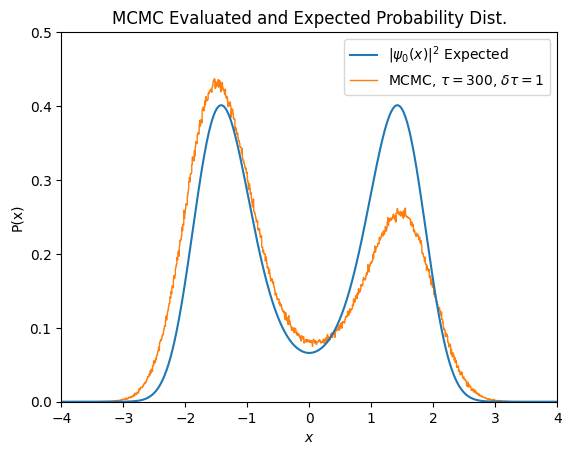

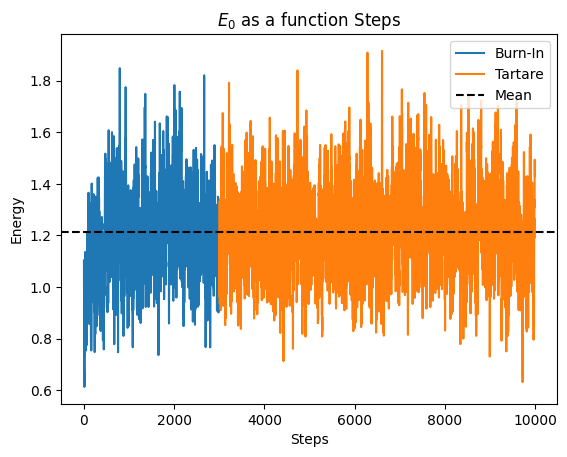

In [6]:
YMIN, YMAX = 0, 0.5 
burnin = int(0.3*SWEEPS)

plt.figure()
plt.plot(x, normed, label=r"$|\psi_0(x)|^2$ Expected")
plt.stairs(prob_hist/np.sum(prob_hist*DX), x_bins, label=f"MCMC, $\\tau = {TAU}$, $\\delta\\tau={DTAU}$")
plt.xlabel(r"$x$")
plt.ylabel(r"P(x)")
plt.ylim([YMIN, YMAX])
plt.xlim([XMIN, XMAX])
plt.title(f"MCMC Evaluated and Expected Probability Dist.")
plt.legend()
plt.show()
# print(MCMCAvg)
plt.figure()
plt.title("$E_0$ as a function Steps")
plt.plot(range(len(E_0_list))[:burnin], E_0_list[:burnin], label="Burn-In")
plt.plot(range(len(E_0_list))[burnin:], E_0_list[burnin:], label="Tartare")
plt.axhline(np.mean(E_0_list[burnin:]),label='Mean',linestyle='--',color='k')
plt.legend(loc='upper right')
plt.ylabel("Energy")
plt.xlabel("Steps")
plt.show()

Problem C : Calculate the energy and probability distribution of the particle from the same simulation
code for a smaller value of τb. What is the expected probability distribution in this case? What does this
correspond to in terms of a statistical mechanics interpretation?

In [7]:
Prob_hist_list=[]


In [8]:
# acceptance_rate_list=[]
TAU_list=[5,10,20,500]

SWEEPS = 100_000
DTAU = 1
HIT = 0.1
burnin = int(0.3 * SWEEPS)

for TAU in TAU_list:
    NTAU = int(TAU/DTAU)
    #reset parameters
    MCMCAvg=[]
    prob_hist = np.zeros(NXBINS)
    x_bins = np.linspace(XMIN, XMAX, NXBINS + 1)
    x_path = np.zeros(NTAU)

    for k in tqdm.tqdm(range(int(SWEEPS))):
        MCMC(x_path, prob_hist,x2Sample,x4Sample)
    Prob_hist_list.append(prob_hist)
    


100%|██████████| 100000/100000 [07:56<00:00, 209.78it/s]


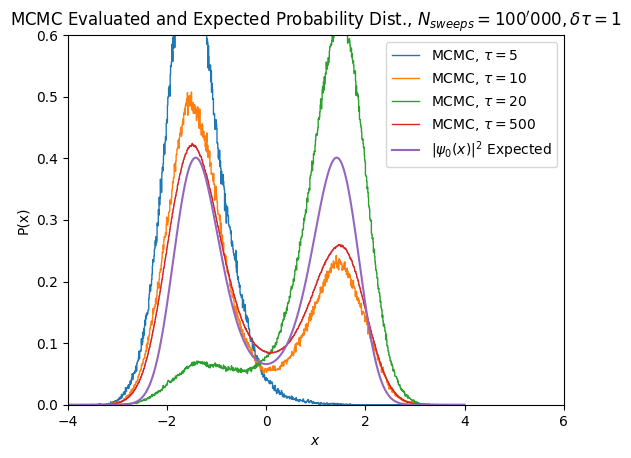

In [9]:
TAU_list=[5,10,20,500]
plt.figure()
for TAU,prob_hist in zip(TAU_list,Prob_hist_list):
    plt.stairs(prob_hist/np.sum(prob_hist*DX), x_bins, label=f"MCMC, $\\tau = {TAU}$")
plt.plot(x, normed, label=r"$|\psi_0(x)|^2$ Expected")
plt.xlabel(r"$x$")
plt.ylabel(r"P(x)")
plt.ylim([YMIN, YMAX+0.1])
plt.xlim([XMIN, XMAX+2])
plt.title("MCMC Evaluated and Expected Probability Dist., $N_{sweeps}=100'000,\delta\\tau=1$")
plt.legend()
plt.show()

Ground state energy analysis

In [10]:
E_0_list=[]
E0list_for_each_Sweeps_list=[]

In [11]:
SWEEPS_list=[1_000,2_000,5_000,10_000,20_000,50_000,100_000]

TAU_list=[5,10,20,50,100,200,500]

DTAU = 1
HIT = 0.1


for SWEEPS in SWEEPS_list:
    burnin = int(0.3 * SWEEPS)
    E_0_list=[]


    
    for TAU in TAU_list:

        #reset parameters
        x2Sample = []
        x4Sample = []
        NTAU = int(TAU/DTAU)
        prob_hist = np.zeros(NXBINS)
        x_bins = np.linspace(XMIN, XMAX, NXBINS + 1)
        x_path = np.zeros(NTAU)

        for k in tqdm.tqdm(range(SWEEPS)):
            MCMC(x_path, prob_hist,x2Sample,x4Sample)
        avgx2 = np.mean(x2Sample[burnin:])
        avgx4 = np.mean(x4Sample[burnin:])

        E_0_list.append(0.5*(3*ALPHA*avgx4 -4*avgx2 + 1/ALPHA))
    E0list_for_each_Sweeps_list.append(E_0_list)

100%|██████████| 100000/100000 [07:28<00:00, 222.93it/s]


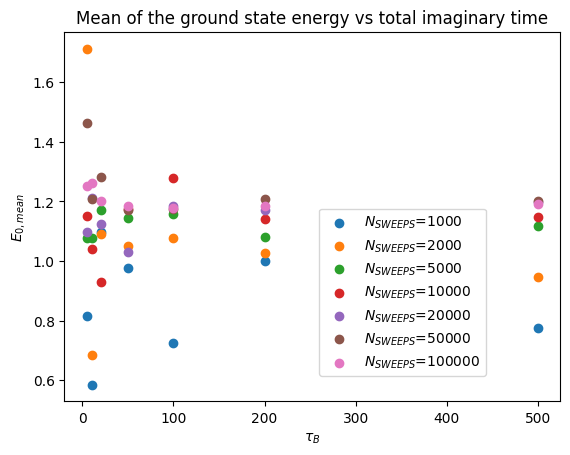

In [12]:
SWEEPS_list=[1_000,2_000,5_000,10_000,20_000,50_000,100_000]
TAU_list=[5,10,20,50,100,200,500]





plt.figure()
for SWEEPS,E_0_list in zip(SWEEPS_list,E0list_for_each_Sweeps_list):
    if SWEEPS == 1_000_000:
        plt.scatter([5,10,20],E_0_list,label=F"$N_{{SWEEPS}}$={SWEEPS}")
    else:
        plt.scatter(TAU_list,E_0_list,label=F"$N_{{SWEEPS}}$={SWEEPS}")
plt.xlabel(r"$\tau_B$")
plt.ylabel(r"$E_{0,mean}$")
plt.title("Mean of the ground state energy vs total imaginary time")
plt.legend(loc="upper left", bbox_to_anchor=(0.5, 0.54))
plt.show()

Acceptance rate analysis

In [13]:
acceptance_rate_list=[]
Rate_for_each_DTAU_list=[]

In [14]:
HIT_list=np.linspace(0.1,6,10)

SWEEPS = 1_000
DTAU_list=[0.25,0.5,1]
TAU = 300

burnin = int(0.3 * SWEEPS)

for DTAU in DTAU_list:
    acceptance_rate_list=[]
    for hit in HIT_list:

        HIT = hit
        #reset parameters
        NTAU = int(TAU/DTAU)
        prob_hist = np.zeros(NXBINS)
        x_bins = np.linspace(XMIN, XMAX, NXBINS + 1)
        x_path = np.zeros(NTAU)

        accepted = 0
        for k in tqdm.tqdm(range(SWEEPS)):
            accepted += MCMC(x_path, prob_hist,x2Sample,x4Sample)
        acceptance_rate_list.append(accepted/SWEEPS/NTAU)
    Rate_for_each_DTAU_list.append(acceptance_rate_list)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 346.01it/s]


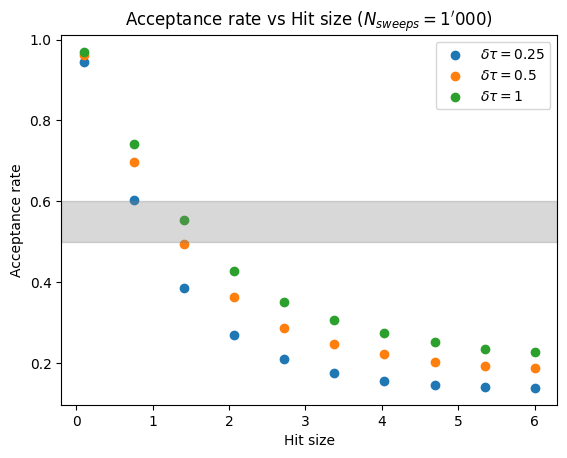

In [16]:
plt.figure()
for DTAU,acceptance_rate_list in zip(DTAU_list,Rate_for_each_DTAU_list):
    plt.scatter(HIT_list,acceptance_rate_list,label=f"$\delta\\tau={DTAU}$")
plt.xlabel(r"Hit size")
plt.ylabel(r"Acceptance rate")
plt.title("Acceptance rate vs Hit size ($N_{sweeps}=1'000$)")
plt.axhspan(0.5, 0.6, color='gray', alpha=0.3)
# plt.savefig('AcceptRatevsHitSweeps10000.jpg')
plt.legend()
plt.show()